# Reproducing the Oxidation State Assignment Model from Jablonka et al.

This notebook reproduces the key methodology and results from:
**"Using collective knowledge to assign oxidation states of metal cations in metal–organic frameworks"**
([DOI: 10.1038/s41557-021-00717-y](https://doi.org/10.1038/s41557-021-00717-y))

## Table of Contents
1. [Environment Setup](#env)
2. [Load Data](#load)
3. [Featurization](#feat)
4. [Model Training](#train)
5. [Evaluation](#eval)
6. [SHAP Analysis](#shap)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')
import pickle
import shap

**Phase 1: Viweing the performance of the pretrained model**

In [2]:
# Load feature matrix and labels
X = np.load("features_all.npy", allow_pickle=True)
y = np.load("labels_all.npy", allow_pickle=True)

# Load structure names (CSD IDs, optional but useful for later)
names_path = r"E:\Projects\Oxidation_used_data\names_all.pkl"

with open(names_path, "rb") as f:
    names = pickle.load(f)
# Check shape
print("Features shape:", X.shape)
print("Labels shape:", y.shape)
print("Example CSD IDs:", names[:5])

Features shape: (211723, 116)
Labels shape: (211723, 1)
Example CSD IDs: ['DEWQUS', 'RIPPEN', 'CIQHOC', 'WIMWIB', 'EMETUL']


In [3]:
# Load the scaler and scale features
scaler = joblib.load("scaler_0.joblib")
X_scaled = scaler.transform(X)

# Load pretrained voting classifier
model = joblib.load("votingclassifier.joblib")

In [4]:
print(X_scaled.shape)

(211723, 116)


In [5]:
# Predict only the first 1000 oxidation states
y_pred = model.predict(X_scaled[:1000])

# (Optional) Evaluate on first 1000 labels
from sklearn.metrics import classification_report

print(classification_report(y[:1000], y_pred))

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       182
           2       1.00      1.00      1.00       596
           3       1.00      0.99      1.00       163
           4       1.00      1.00      1.00        30
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00        25

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



Accuracy: 0.997
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       182
           2       1.00      1.00      1.00       596
           3       1.00      0.99      1.00       163
           4       1.00      1.00      1.00        30
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00        25

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



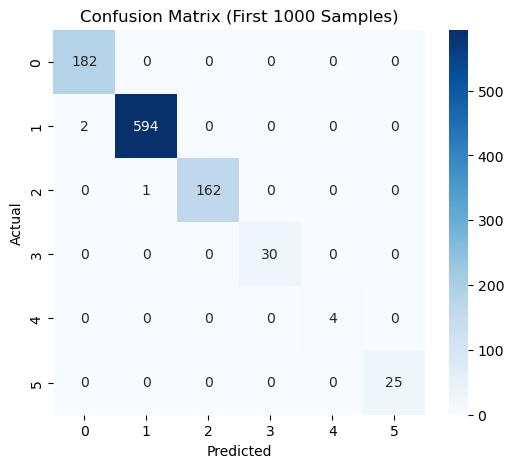

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# True vs predicted for the first 1000
y_true_1000 = y[:1000]
y_pred_1000 = model.predict(X_scaled[:1000])

# Accuracy
print("Accuracy:", accuracy_score(y_true_1000, y_pred_1000))

# Classification report
print(classification_report(y_true_1000, y_pred_1000))

# Confusion matrix
conf = confusion_matrix(y_true_1000, y_pred_1000)
plt.figure(figsize=(6, 5))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (First 1000 Samples)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Features relative importance of the pre-trained model**

In [7]:
df = pd.read_csv(r"E:\Projects\Oxidation_used_data\all_data.csv")
print(df.columns.tolist())

['Unnamed: 0', 'local difference in MendeleevNumber', 'local difference in Column', 'local difference in Row', 'local difference in Electronegativity', 'local difference in NsValence', 'local difference in NpValence', 'local difference in NdValence', 'local difference in NfValence', 'local difference in NValence', 'local difference in NsUnfilled', 'local difference in NpUnfilled', 'local difference in NdUnfilled', 'local difference in NfUnfilled', 'local difference in NUnfilled', 'local difference in GSbandgap', 'local signed difference in MendeleevNumber', 'local signed difference in Column', 'local signed difference in Row', 'local signed difference in Electronegativity', 'local signed difference in NsValence', 'local signed difference in NpValence', 'local signed difference in NdValence', 'local signed difference in NfValence', 'local signed difference in NValence', 'local signed difference in NsUnfilled', 'local signed difference in NpUnfilled', 'local signed difference in NdUnfill

In [8]:
X = np.load("features_all.npy")
print(X.shape)  # Should print (n, 116)

(211723, 116)


In [9]:
import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt

# === Step 1: Load the full dataset ===
df = pd.read_csv(r"E:\Projects\Oxidation_used_data\all_data.csv")

# === Step 2: Separate labels ===
y_df = df["oxidationstate"]

# === Step 3: Drop non-numeric columns ===
X_df = df.drop(columns=["oxidationstate"])
X_df_numeric = X_df.select_dtypes(include=["number"])

# === Step 4: Align to expected feature size (116) ===
# The scaler was trained on exactly 116 features
X_df_aligned = X_df_numeric.iloc[:1000, :116]

# === Step 5: Load pretrained scaler and apply ===
scaler = joblib.load("scaler_0.joblib")
X_scaled_shap = scaler.transform(X_df_aligned)

# === Step 6: Load pretrained model ===
model_shap = joblib.load("votingclassifier.joblib")

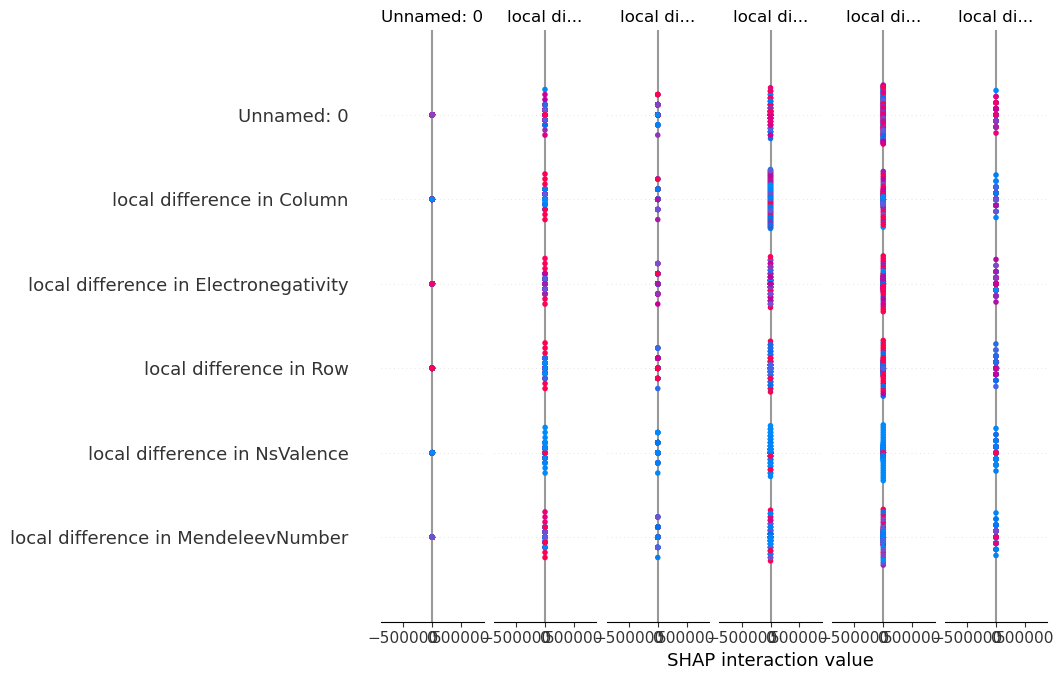

In [10]:
# === Step 7: Create SHAP explainer from one base model (e.g., Extra Trees) ===
base_model = model_shap.estimators[0].base_estimator    # Usually ExtraTreesClassifier
explainer = shap.Explainer(base_model, X_scaled_shap[:100])  # Use first 100 for SHAP

# === Step 8: Compute SHAP values ===
shap_values = explainer(X_scaled_shap[:100])

# === Step 9: Plot SHAP summary (global feature importance) ===
shap.summary_plot(shap_values, X_scaled_shap[:100], feature_names=X_df_aligned.columns)

**Phase 2: Regenerating the workflow to learn from the paper**

***Step 1: Viweing their parsed data***

In [11]:
# Load structure names (CSD IDs, optional but useful for later)
names_path = r"E:\Projects\Oxidation_used_data\names_all.pkl"

with open(names_path, "rb") as f:
    names = pickle.load(f)

print("Total environments loaded:", len(names))
print("Example records:")
for i in range(-5, 0):
    print(f"CSD ID: {names[i]}, Label: {y[i]}")

Total environments loaded: 211723
Example records:
CSD ID: LOPFEB, Label: [1]
CSD ID: DIYDIZ, Label: [3]
CSD ID: UGEBAJ, Label: [2]
CSD ID: EQITON, Label: [2]
CSD ID: TEZDOU, Label: [3]


In [12]:
import pickle

names_path = r"E:\Projects\Oxidation_used_data\names_all.pkl"
with open(names_path, "rb") as f:
    names = pickle.load(f)

print("Type of object:", type(names))
print("Length:", len(names))
print("First 10 entries:", names[:10])

Type of object: <class 'list'>
Length: 211723
First 10 entries: ['DEWQUS', 'RIPPEN', 'CIQHOC', 'WIMWIB', 'EMETUL', 'FAMMOW', 'FENKUF', 'XOKVUP', 'JIRLII', 'PEBFEI']


***Excluded Datasets***

In [13]:
import pickle

clash_path = r"E:\Projects\materials-ml-projects-\Projects\P_5_Oxidation_State_Assignment\learn_mof_ox_state\data\clashing_atoms.pkl"   # 'r' denotes read mode (raw string)
with open(clash_path, "rb") as f:                                                                                                       # 'rb' denotes read-binary mode
    clashing_ids = pickle.load(f)

print("Number of structures with atomic overlaps:", len(clashing_ids))
print("First 10 excluded CSD IDs:", clashing_ids[:10])

Number of structures with atomic overlaps: 6926
First 10 excluded CSD IDs: ['ABEHOH', 'ABEXAI', 'ABULEP', 'ABZCUH04', 'ACABEM', 'AGOTAS', 'AGOPIV', 'AGEWOB', 'AGOPAN', 'AGOJEN']


***Step 2: Demonstrating the expected difference between scaler_0 vs StandardScaler***

In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib

# Load the scaler and transform
scaler_loaded = joblib.load("scaler_0.joblib")
X_scaled_loaded = scaler_loaded.transform(X)

# Fit a new scaler on the same X and transform
scaler_manual = StandardScaler().fit(X)
X_scaled_manual = scaler_manual.transform(X)

# Check if the transformed arrays are the same
print("Transformed X equal?", np.allclose(X_scaled_loaded, X_scaled_manual))
print("Means same?", np.allclose(scaler_loaded.mean_, scaler_manual.mean_))
print("Scales same?", np.allclose(scaler_loaded.scale_, scaler_manual.scale_))

# Optionally, print any difference if they are not the same
if not np.allclose(X_scaled_loaded, X_scaled_manual):
    print("Max absolute difference:", np.max(np.abs(X_scaled_loaded - X_scaled_manual)))


Transformed X equal? False
Means same? False
Scales same? False
Max absolute difference: 77655.73938969693


**Figuring out the featurization strategy**   
A short summary of the paper's featurize.py file.

In [15]:
METAL_CENTER_FEATURES = [
    "column", "row", "valenceelectrons", "diffto18electrons", "sunfilled", "punfilled", "dunfilled"
]
GEOMETRY_FEATURES = ["crystal_nn_fingerprint", "behler_parinello"]
CHEMISTRY_FEATURES = ["local_property_stats"]

DEFAULT_FEATURE_SET = (
    ["local_property_stats"]  # neighbor chemistry
    + ["column", "row", "valenceelectrons", "diffto18electrons", "sunfilled", "punfilled", "dunfilled"]  # metal identity
    + ["crystal_nn_no_steinhardt"]  # geometry (order parameters)
)

**Step 3: replicating the key methodologies and results of the paper With newly scrapped 'Materials project' dataset.**  
The paper claims:
'the model that was trained only on MOFs can be transferred to
other types of material, such as binary ionic solids or simple metal
complexes.' Hence, I choose to go with binary ionic solids.

In [2]:
import sys
print(sys.executable)


c:\Users\sayee\miniconda3\envs\oxistate\python.exe


**a. Fetching the data**

In [2]:
import sys
sys.path.append(r"E:\Projects\oximachine_featurizer") 
from pymatgen.ext.matproj import MPRester
from pymatgen.core.periodic_table import Element
from pymatgen.core import Structure
import numpy as np
from oximachine_featurizer import featurize

API_KEY = "gJvlWQFS6oWgMkCzghhy8YMSAYjtEv1B"

all_metals = [el.symbol for el in Element if el.is_metal]
anions = ["O", "S", "Se", "F", "Cl", "Br", "I", "N", "P"]

a.1: Materials project:  
these data dont have a CIF attribute. thats why in the next cell OQMD will be used

In [4]:
# X, y, mp_ids, metals = [], [], [], []

# with MPRester(API_KEY) as mpr:
#     for metal in all_metals:
#         for anion in anions:
#             if metal == anion:
#                 continue
#             docs = mpr.summary.search(
#                 elements=[metal, anion],
#                 fields=["material_id", "formula_pretty", "cif", "elements"]
#             )
#             for d in docs:
#                 try:
#                     struct = Structure.from_str(d.cif, fmt="cif")
#                     struct.add_oxidation_state_by_guess()
#                     features, metal_indices, metal_symbols = featurize(struct)
#                     for j, idx in enumerate(metal_indices):
#                         el = struct[idx].specie
#                         ox = el.oxi_state if hasattr(el, "oxi_state") else None
#                         if ox is not None:
#                             X.append(features[j])
#                             y.append(ox)
#                             mp_ids.append(d.material_id)
#                             metals.append(str(el))
#                 except Exception as e:
#                     print(f"{d.material_id}: {e}")

# X = np.array(X)
# y = np.array(y)
# print("Feature matrix shape:", X.shape)
# print("Labels shape:", y.shape)
# print("Example labels:", y[:10])

a.2: OQMD:   
they have partial ICSD tagged data which can be adapted to the paper more easily.

In [1]:
import requests
import pandas as pd

base_url = "http://oqmd.org/oqmdapi/formationenergy"
fields = "name,entry_id,icsd_id,unit_cell,composition_generic"
batch_size = 100
offset = 0
max_entries = 15000
all_entries = []

while len(all_entries) < max_entries:
    url = (
        f"{base_url}?fields={fields}"
        f"&format=json"
        f"&limit={batch_size}"
        f"&offset={offset}"
    )
    resp = requests.get(url)
    if resp.status_code != 200:
        print("Error:", resp.text[:300])
        break
    data = resp.json()
    if not data or not data.get("data"):
        break
    # Only collect up to max_entries
    for row in data["data"]:
        if row.get("icsd_id") and str(row["icsd_id"]).strip() != "0":
            all_entries.append(row)
            if len(all_entries) >= max_entries:
                break
    if len(data["data"]) < batch_size or len(all_entries) >= max_entries:
        break
    offset += batch_size

# Save first 15,000 ICSD-tagged entries
df = pd.DataFrame(all_entries[:max_entries])
df.to_csv("oqmd_icsd_unitcell_composition_name.csv", index=False)
print(f"Saved {len(df)} ICSD-tagged entries with unit cell and composition.")

Saved 15000 ICSD-tagged entries with unit cell and composition.


In [ ]:
import pandas as pd

data = pd.read_csv("oqmd_icsd_unitcell_composition_name.csv")
print(data.head())
print(data.info())

  name  entry_id  icsd_id composition_generic  \
0   Ne      4698    24787                   A   
1   La      8130    43568                   A   
2   Pr      8132    43570                   A   
3   Kr      8203    43726                   A   
4    V      7503    41504                   A   

                                           unit_cell  
0  [[2.2145, -2.2145, 0.0], [-2.2145, 0.0, -2.214...  
1  [[2.113933, 2.113933, 2.113933], [2.113933, -2...  
2  [[2.077907, 2.077907, 2.077907], [2.077907, -2...  
3  [[2.776996, -2.776996, 0.0], [-2.776996, 0.0, ...  
4  [[1.890584, -1.890584, 0.0], [-1.890584, 0.0, ...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name                 15000 non-null  object
 1   entry_id             15000 non-null  int64 
 2   icsd_id              15000 non-null  int64 
 3   composition_gener

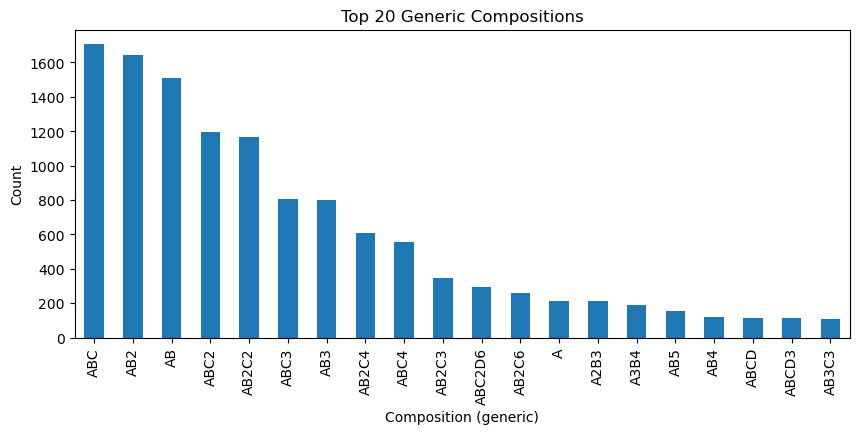

In [3]:
import matplotlib.pyplot as plt

data['composition_generic'].value_counts().head(20).plot(kind='bar', figsize=(10,4))
plt.title("Top 20 Generic Compositions")
plt.ylabel("Count")
plt.xlabel("Composition (generic)")
plt.show()


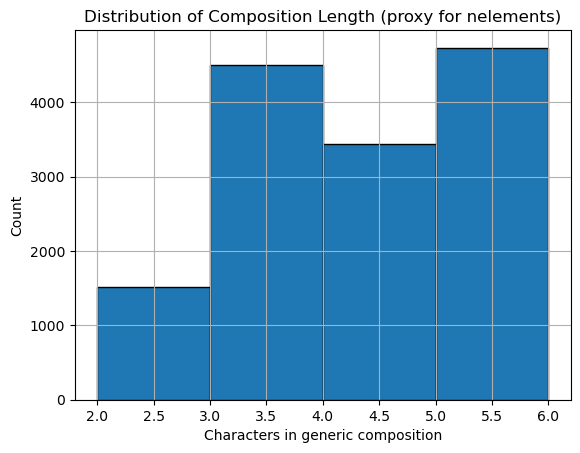

In [4]:
data['nelements'] = data['composition_generic'].str.len()  # crude proxy
data['nelements'].hist(bins=range(2,7), edgecolor='black')
plt.title("Distribution of Composition Length (proxy for nelements)")
plt.xlabel("Characters in generic composition")
plt.ylabel("Count")
plt.show()

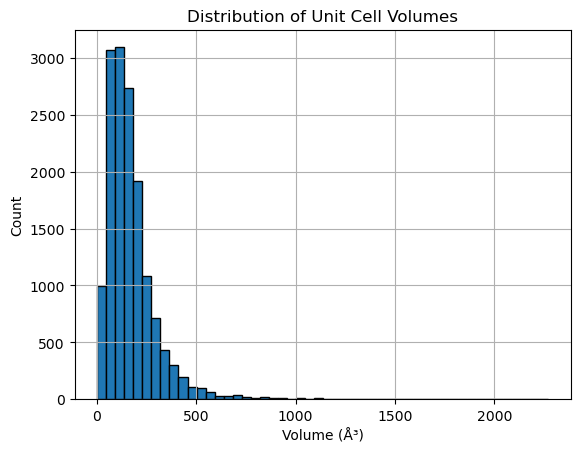

In [5]:
import numpy as np

def cell_volume(cell_str):
    try:
        arr = np.array(eval(cell_str))
        return abs(np.linalg.det(arr))
    except:
        return None

data['volume'] = data['unit_cell'].apply(cell_volume)
data['volume'].hist(bins=50, edgecolor='black')
plt.title("Distribution of Unit Cell Volumes")
plt.xlabel("Volume (Å³)")
plt.ylabel("Count")
plt.show()

In [6]:
print(data[['name', 'composition_generic', 'icsd_id', 'volume']].sample(5))

           name composition_generic  icsd_id      volume
13500      PtO2                 AB2    30443   65.815943
2022    SrGaGeH                ABCD   246818   78.171007
8112     BaCoS2                ABC2    75515  169.131558
5414   Y2Al3Si2              A2B2C3    75228  134.240012
3712   SmGa2Pd2               AB2C2   240091   95.203836


In [7]:
from pymatgen.io.cif import CifParser

entry_id = 123456  # example
cif_file = f"oqmd_icsd_cifs/{entry_id}.cif"
parser = CifParser(cif_file)
structure = parser.get_structures()[0]
structure.add_oxidation_state_by_guess()
for site in structure:
    print(site.species_string, site.specie.oxi_state)


FileNotFoundError: [Errno 2] No such file or directory: 'oqmd_icsd_cifs/123456.cif'